Style GAN

In [1]:
#import stuff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Conv2DTranspose, LeakyReLU
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import numpy as np

Parameters

In [2]:
batch_size = 32
depth = 32

Load and process the data

In [3]:
#load raw data
raw_ds = tf.keras.preprocessing.image_dataset_from_directory('D:\Datasets\keras_png_slices_data\keras_png_slices_train', labels=None, color_mode='grayscale', batch_size=batch_size)
print(raw_ds)

#check range of values in raw data
image_batch = next(iter(raw_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

#normalise the data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
norm_ds = raw_ds.map(lambda img: (normalization_layer(img)))

#check range of values in raw data
image_batch = next(iter(norm_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Found 9664 files belonging to 1 classes.
<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>
0.0 255.0
-1.0 1.0


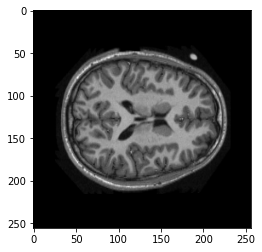

In [4]:
#visualise raw data
for images in raw_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

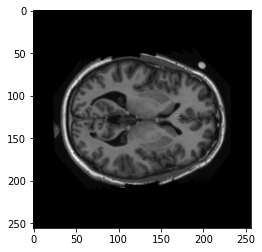

In [5]:
#visualise norm data
for images in norm_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

Networks

In [ ]:
#define generator
#mapping network
    #for taking an image (style) and converting it to latent space to use in the weights of the synthesis network
#synthesis network
    #network used to generate images using input style and noise


def make_generator_model ():
    model = tf.keras.Sequential()
    return model

In [ ]:
#create generator
generator = make_generator_model()

In [ ]:
#define discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    return model

In [ ]:
#create discriminator
discriminator = make_discriminator_model()

Training

In [ ]:
#define training step

In [ ]:
#define training loop

In [ ]:
#run training loop

Visualise outcome

In [ ]:
#losses and inference